In [1]:
import torch
from functions import get_loader, plot_histories, plot_history
from ae_functions import train_autoencoder, validate_cae, visualize_latent_space, visualize_reconstruction, get_latent_dataset
from ae_models import DeepCAE, DeepBatchCAE, SimpleCAE, SimpleBatchCAE, SimpleCAE_Dropout
import torch.nn as nn
from mlp_functions import train_mlp, validate_mlp
from mlp_models import rawMLP, MLP, dropout_MLP
import matplotlib.pyplot as plt

In [7]:
##### CONFIG
NUM_EPOCHS = 5
LR_RATE = 1e-3
BATCH_SIZE = 8
WEIGHT_DECAY = 1e-5

DEVICE = ""
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using GPU...")
else:
    DEVICE = torch.device("cpu")
    print("CUDA is not available. Using CPU...")

BASE_PATH = 'C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/data'

# Define the tool names and actions
TOOL_NAMES = ['hook', 'ruler', 'spatula', 'sshot']
ACTIONS = ['left_to_right', 'pull', 'push', 'right_to_left']

# All available object names
OBJECTS = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
            '5_blackCoinbag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg','9_pumpkinToy',
            '10_tomatoCan', '11_boxMilk', '12_containerNuts', '13_cornCob', '14_yellowFruitToy',
            '15_bottleNailPolisher', '16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

sensor_color = "color"
sensor_left = "icub_left"
sensor_right = "icub_right"
SENSOR = sensor_right

CUDA is available. Using GPU...


In [8]:
train_loader = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, SENSOR, "training", batch_size=BATCH_SIZE)
val_loader = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, SENSOR, "validation", batch_size=BATCH_SIZE)
test_loader = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, SENSOR, "testing", batch_size=BATCH_SIZE)

Epoch [1/5], AVG Loss: 0.5178, AVG PSNR: 17.4748, AVG SSIM: 0.7024


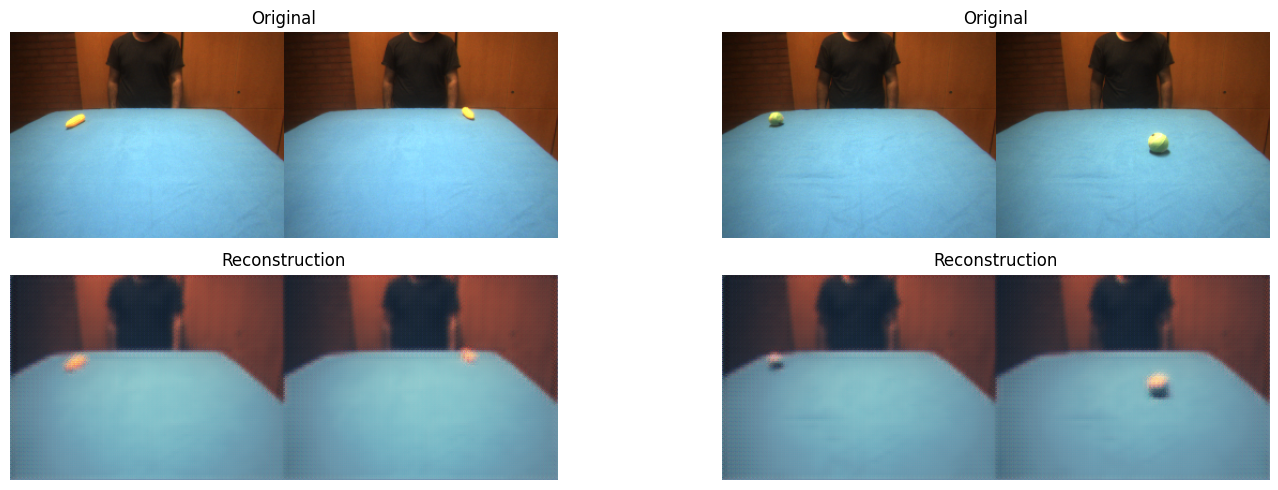

Epoch [2/5], AVG Loss: 0.4512, AVG PSNR: 28.5425, AVG SSIM: 0.9707


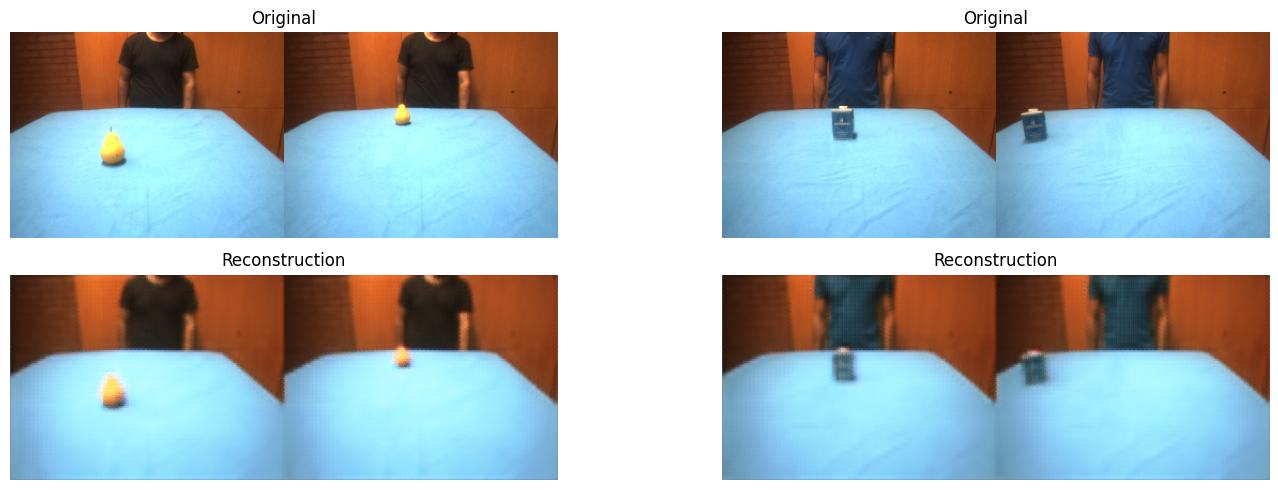

Epoch [3/5], AVG Loss: 0.4484, AVG PSNR: 30.7358, AVG SSIM: 0.9834


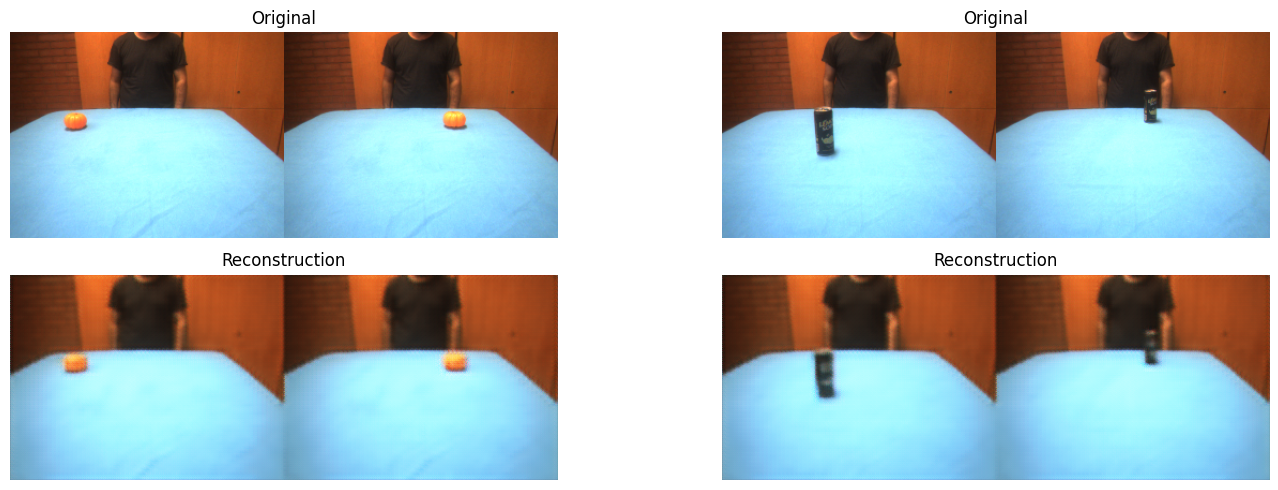

Epoch [4/5], AVG Loss: 0.4477, AVG PSNR: 31.6830, AVG SSIM: 0.9865


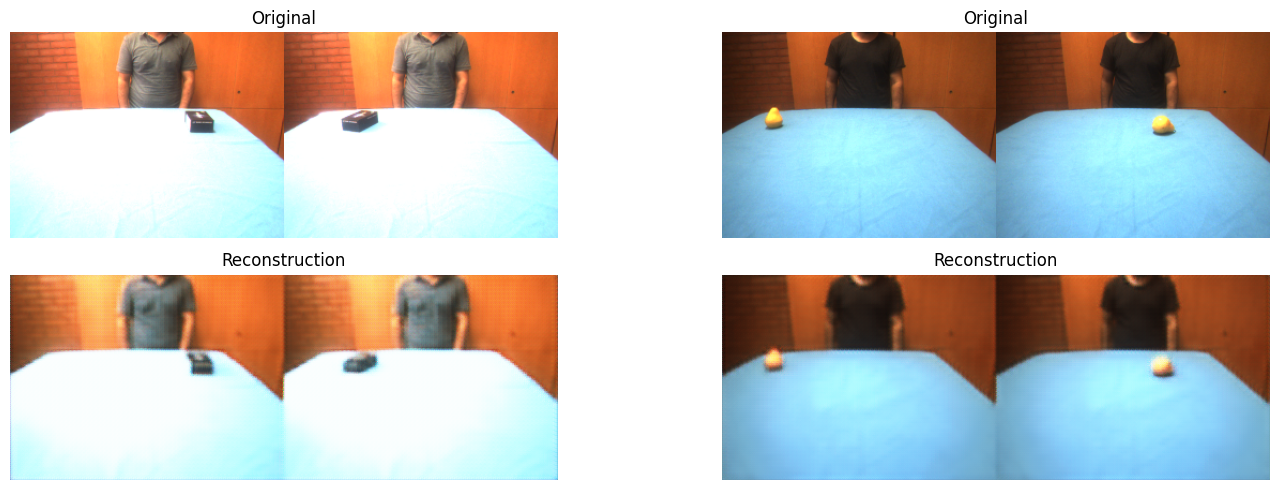

Epoch [5/5], AVG Loss: 0.4475, AVG PSNR: 32.1922, AVG SSIM: 0.9878


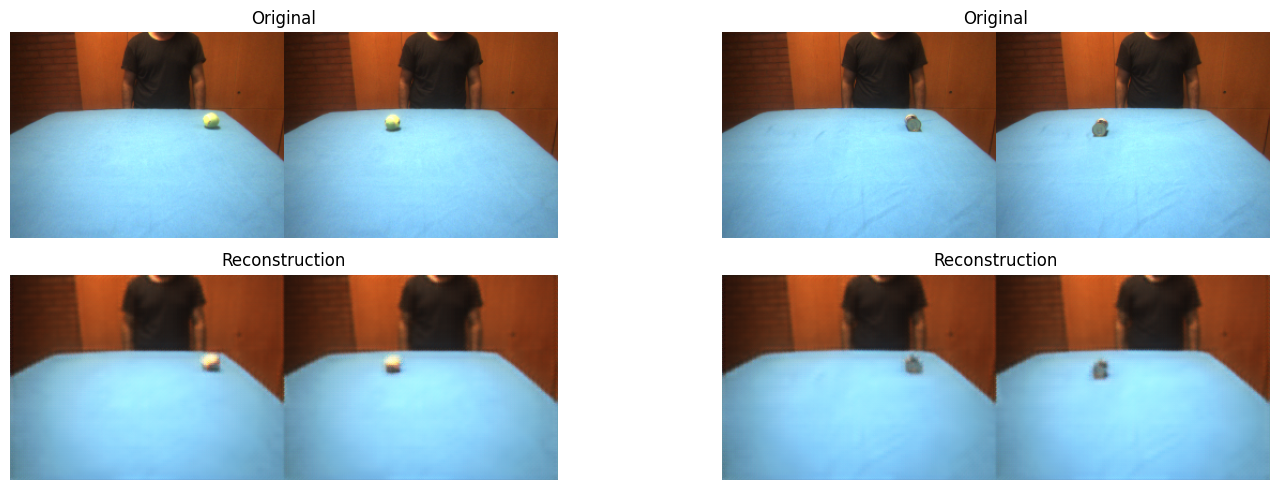

Average Validation Loss: 0.4473461087793112
Average PSNR: 32.7568543441021
Average SSIM: 0.9833433587848676


In [9]:
# cae_lossfunction = nn.MSELoss()
cae_lossfunction = nn.BCELoss()

# Training loop
#cae = SimpleCAE().to(DEVICE)
cae = SimpleBatchCAE().to(DEVICE)
#cae = SimpleCAE_Dropout().to(DEVICE)
#cae = DeepCAE().to(DEVICE)
#cae = DeepBatchCAE().to(DEVICE)
optimizer= torch.optim.Adam(cae.parameters(), lr=LR_RATE)
# optimizer = torch.optim.SGD(cae.parameters(), lr=LR_RATE, momentum=0.9)
# optimizer = torch.optim.AdamW(cae.parameters(), lr=LR_RATE, weight_decay=1e-2)

trained_cae, cae_epoch_loss_history = train_autoencoder(cae,\
                                                        train_loader,\
                                                        cae_lossfunction,\
                                                        optimizer,\
                                                        is_depth=False,\
                                                        num_epochs=NUM_EPOCHS,\
                                                        device=DEVICE,\
                                                        visualize=True)

avg_val_loss, cae_validation_loss_history = validate_cae(trained_cae, test_loader, cae_lossfunction, is_depth = False, device = DEVICE)

In [11]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights/simplebatchcae_ne5_b8_right.pth"
torch.save(trained_cae.state_dict(), model_path)

In [5]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights/deepbatchcae_ne5_b8_.pth"
trained_cae = DeepBatchCAE().to(DEVICE)
trained_cae.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [13]:
# Config MLP
mlp_lossfunction = nn.CrossEntropyLoss()  # Loss function
output_dim = 4 
NUM_EPOCHS = 5

# Extract features from the train and validation sets
train_dataset = get_latent_dataset(trained_cae, val_loader)
val_dataset = get_latent_dataset(trained_cae, test_loader)

# Create DataLoaders for the extracted features
mlp_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mlp_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize
input_dim = train_dataset[:][0].size(1)
mlp = MLP(input_dim, output_dim).to(DEVICE)
#mlp = MLP_Dropout(input_dim, output_dim).to(DEVICE)
#mlp = rawMLP(input_dim, output_dim).to(DEVICE)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=LR_RATE)

# Train the model
trained_mlp = train_mlp(mlp, mlp_lossfunction, mlp_optimizer, mlp_train_loader, NUM_EPOCHS, DEVICE)

# Validate the model
validate_mlp(mlp, mlp_lossfunction, mlp_val_loader, DEVICE)

Epoch [1/5], Train Loss: 5.9456
Training Accuracy: 0.3781
Training Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.39      0.39       160
           1       0.37      0.41      0.39       160
           2       0.42      0.40      0.41       160
           3       0.35      0.31      0.32       160

    accuracy                           0.38       640
   macro avg       0.38      0.38      0.38       640
weighted avg       0.38      0.38      0.38       640

Epoch [2/5], Train Loss: 0.8191
Training Accuracy: 0.7453
Training Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       160
           1       0.74      0.73      0.73       160
           2       0.78      0.76      0.77       160
           3       0.70      0.78      0.74       160

    accuracy                           0.75       640
   macro avg       0.75      0.75      0.75       640
weigh

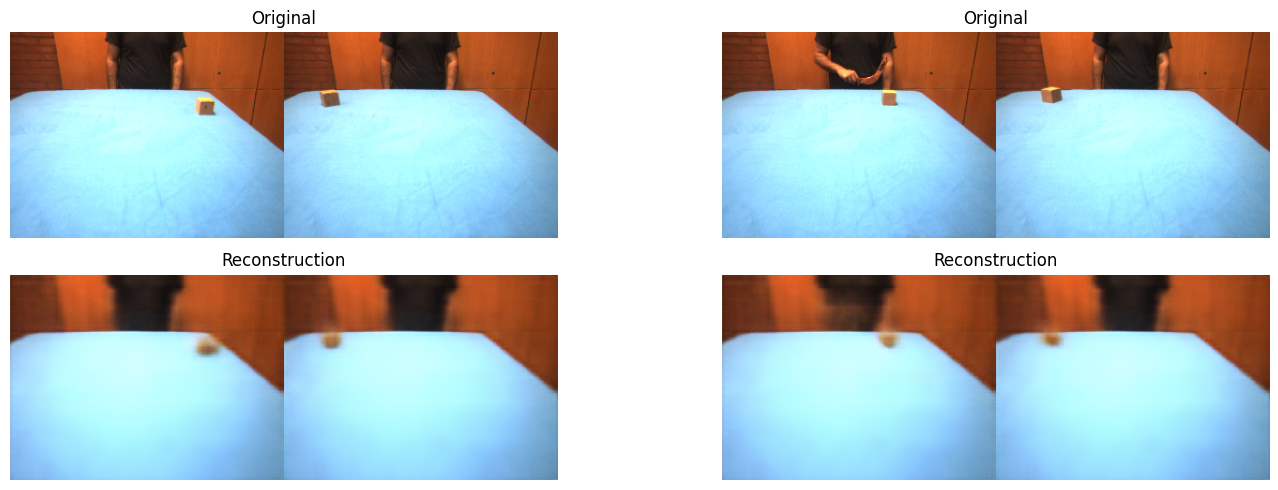

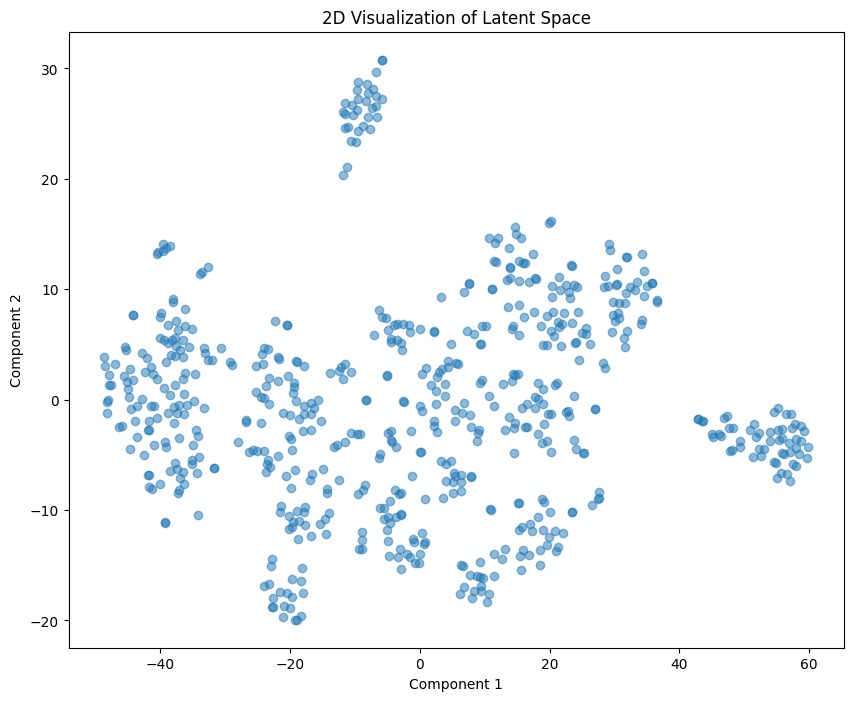

In [7]:
#plot_histories(cae_batch_loss_history, cae_validation_loss_history)
visualize_reconstruction(trained_cae, test_loader, num_samples=2)
visualize_latent_space(trained_cae, test_loader, n_components=2)
# plot_history(mlp_epoch_avg_losses)
# plot_history(mlp_epoch_accuracy)